In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import sys
import os
from pathlib import Path

In [4]:
BASE_PATH = Path(os.path.abspath('')).parent.parent.parent
sys.path.append(str(BASE_PATH))

In [5]:
from bandits.algorithms import *
from bandits.reward_functions import *
from replay_engines.backtester import run_backtest
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import datetime

import matplotlib.pyplot as plt
import scienceplots

%matplotlib inline

# plt.style.use(['science','ieee'])
# plt.style.use(['science','nature'])

In [6]:
x = np.linspace(0, 2*np.pi, 1500)


portfolio = pd.DataFrame(
    {
#         "Class 1": np.array([x[i] + 3.0 if 0 <= i < 500 else x[i] + 1.0 for i in range(len(x))]),
#         "Class 2": np.array([x[i] + 4.0 if 500 <= i < 1000 else x[i] + 2.0 for i in range(len(x))]),
#         "Class 3": np.array([x[i] + 5.0 if 1000 <= i <= 1500 else x[i] + 0.5 for i in range(len(x))]),
        "Class 1": np.sin(x),
        "Class 2": 2*np.sin(2*x),
        "Class 3": 3*np.cos(2*x),
    }
)
portfolio.index = x

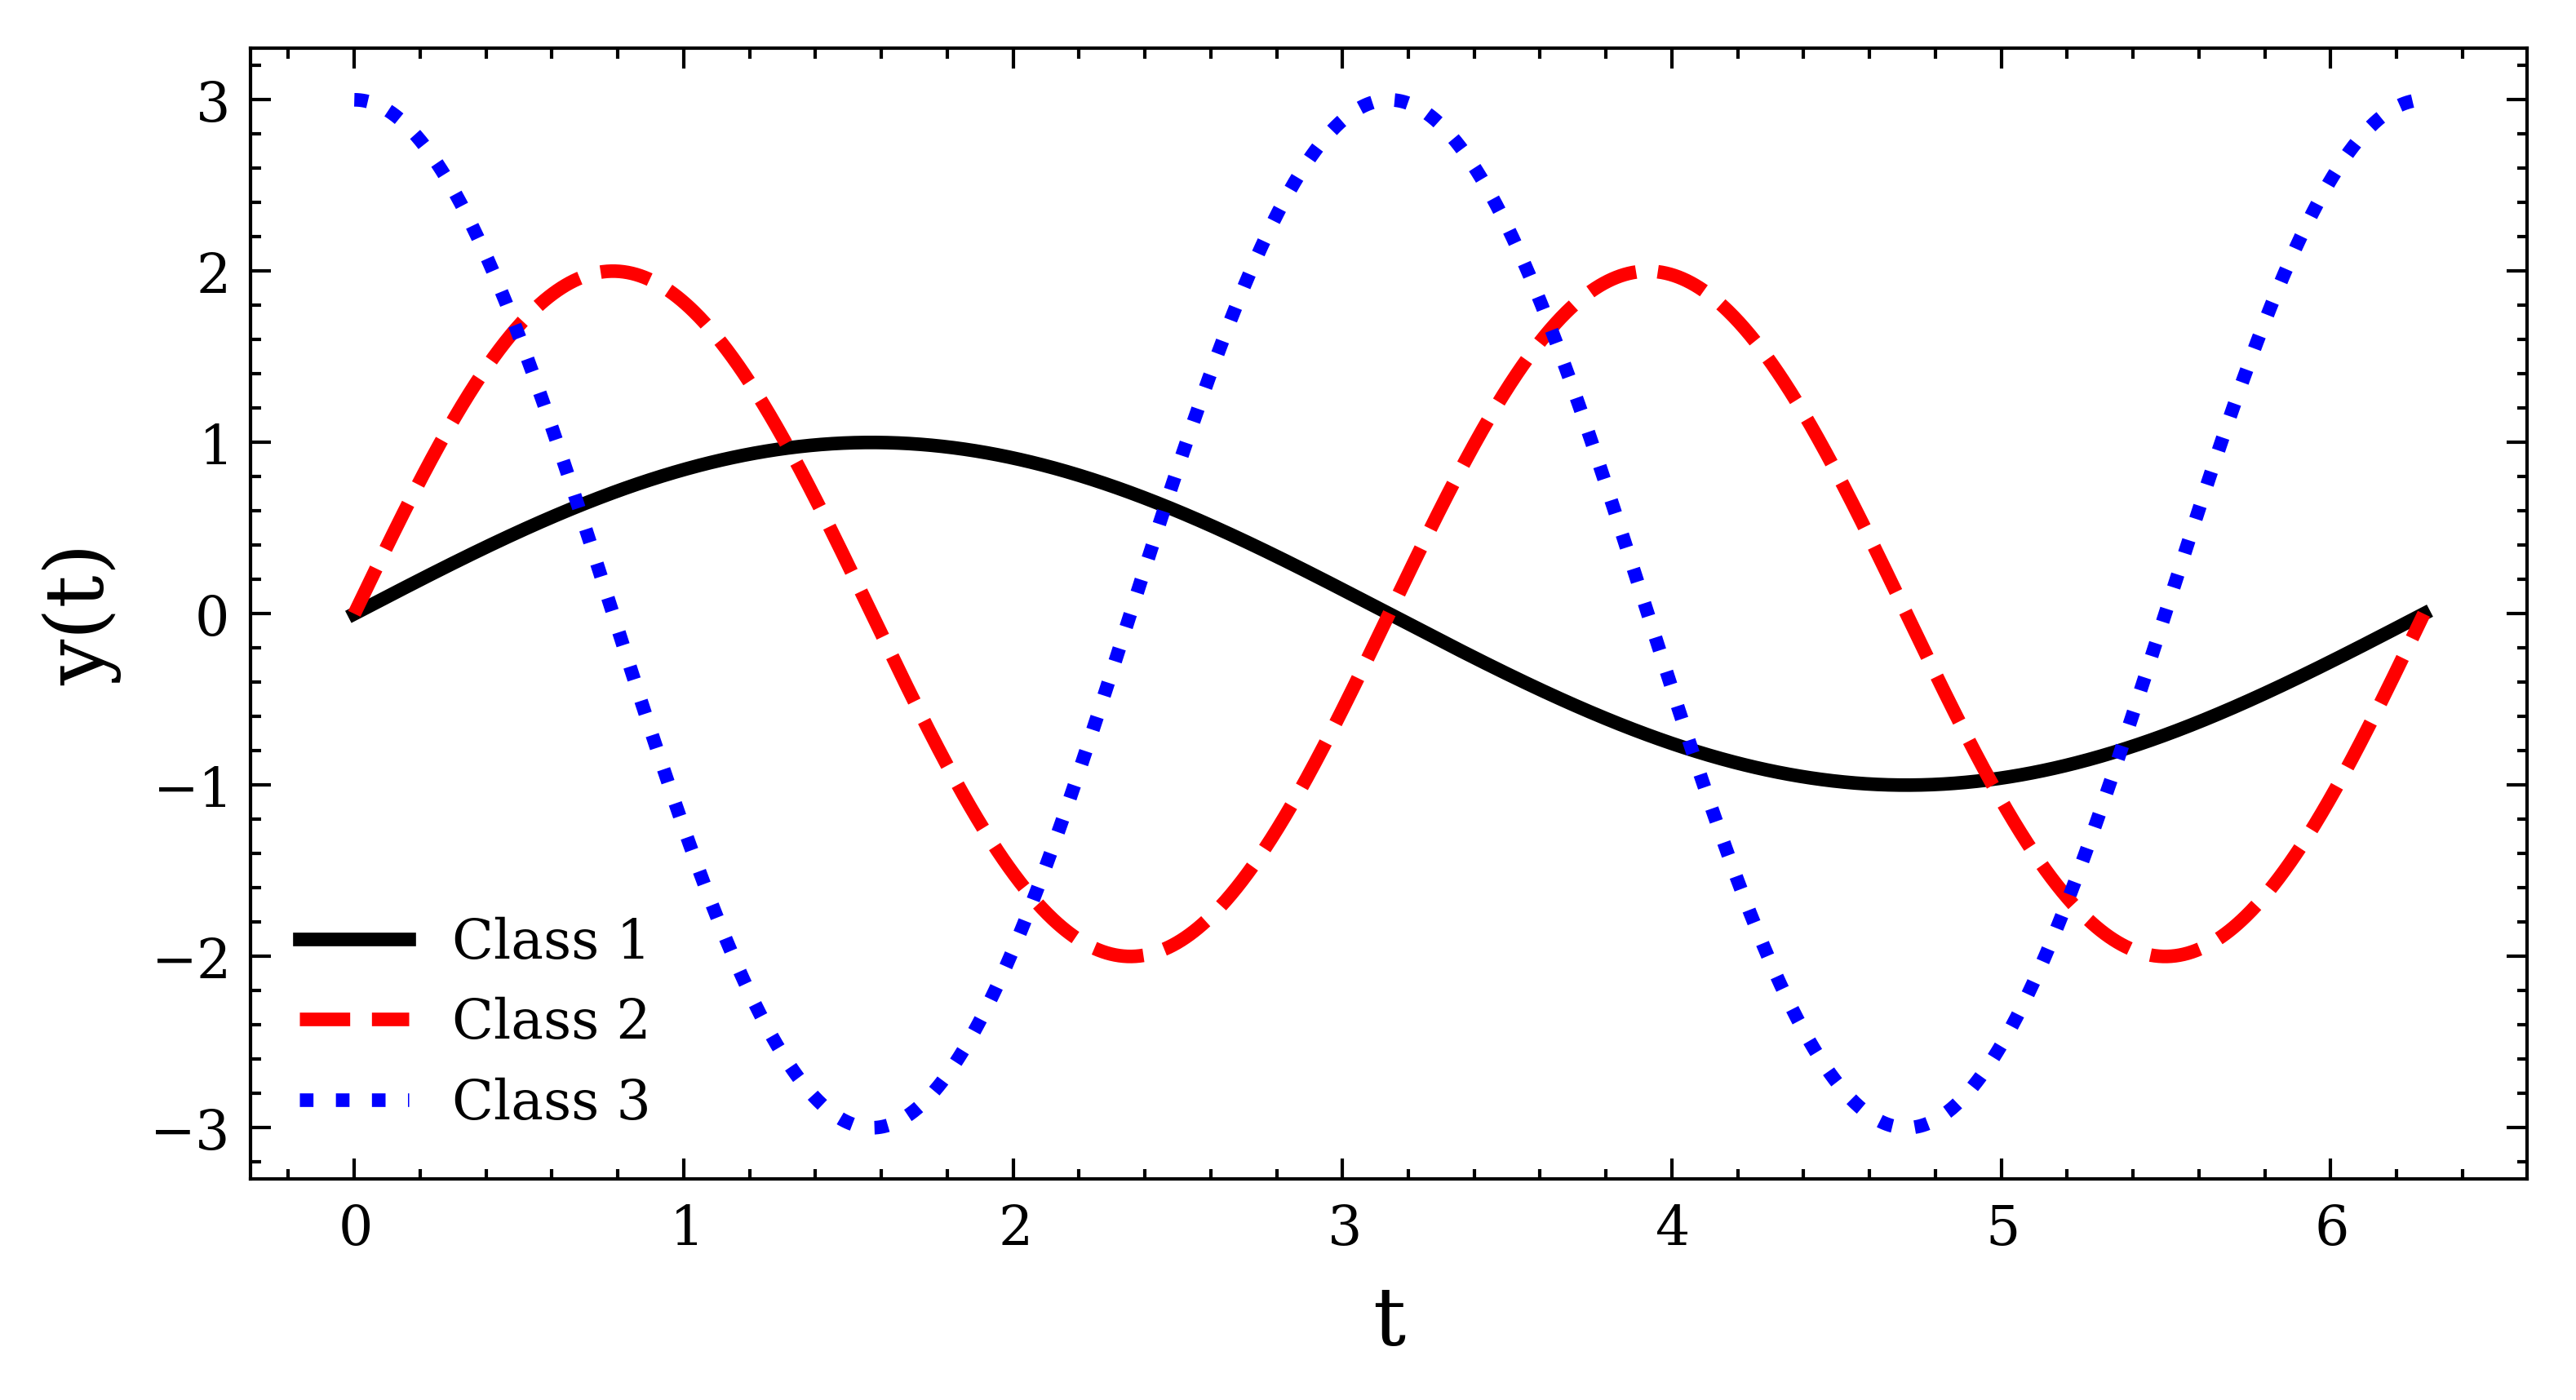

In [7]:
with plt.style.context(['science', 'ieee', 'no-latex']):
#     fig, ax = plt.subplots(figsize=(4, 4))
    portfolio.plot(figsize=(6, 3), linewidth=2)
    plt.xlabel('t', fontsize=12)
    plt.ylabel('y(t)', fontsize=12)
    plt.savefig('01_classes.jpg', dpi=600)

## 1- Investigating the Rewards and Regrets

In [41]:
n_sim = 50
shift = 0
polices = {
    "ADTS (min)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "min", "w": 30},
        "agents": [],
    },
    "F-DSW TS (min)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "min", "n": 30},
        "agents": [],
    },
    # "ADTS (max)": {
    #     "policy_name": "AdaptiveDiscountedThompsonSampling",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "max", "w": 30},
    #     "agents": [],
    # },
    # "F-DSW TS (max)": {
    #     "policy_name": "CavenaghiFDSWTS",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "max", "n": 30},
    #     "agents": [],
    # },
    # "ADTS (mean)": {
    #     "policy_name": "AdaptiveDiscountedThompsonSampling",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "mean", "w": 30},
    #     "agents": [],
    # },
    # "F-DSW TS (mean)": {
    #     "policy_name": "CavenaghiFDSWTS",
    #     "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "mean", "n": 30},
    #     "agents": [],
    # },
    "D TS": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99},
        "agents": [],
    },
    "Classical TS": {
        "policy_name": "ThompsonSampling",
        "args": {"n_arms": portfolio.shape[1]},
        "agents": [],
    },
    "D UCB": {
        "policy_name": "DiscountedUCB1",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.1},
        "agents": [],
    },
    "SW UCB": {
        "policy_name": "SlidingWindowUCB1",
        "args": {"n_arms": portfolio.shape[1], "w": 50},
        "agents": [],
    },
    "UCB1": {
        "policy_name": "UCB1",
        "args": {"n_arms": portfolio.shape[1]},
        "agents": [],
    },
    "$\epsilon$-Greedy": {
        "policy_name": "EpsilonGreedy",
        "args": {"n_arms": portfolio.shape[1], "epsilon": 0.02},
        "agents": [],
    },
}
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=LastReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["rewards_mxt"] = rewards_mxt
    polices[policy_name]["regret_mxt"] = regret_mxt
    polices[policy_name]["std_reward"] = np.std(rewards_mxt, axis=1)
    polices[policy_name]["mean_reward"] = np.mean(rewards_mxt, axis=1)
    polices[policy_name]["std_regret"] = np.std(regret_mxt, axis=1)
    polices[policy_name]["mean_regret"] = np.mean(regret_mxt, axis=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.04it/s]


In [42]:
from colour import Color

blue = Color("red", luminance=0.5)
colors = list(blue.range_to(Color("blue", luminance=0.3), len(polices)))

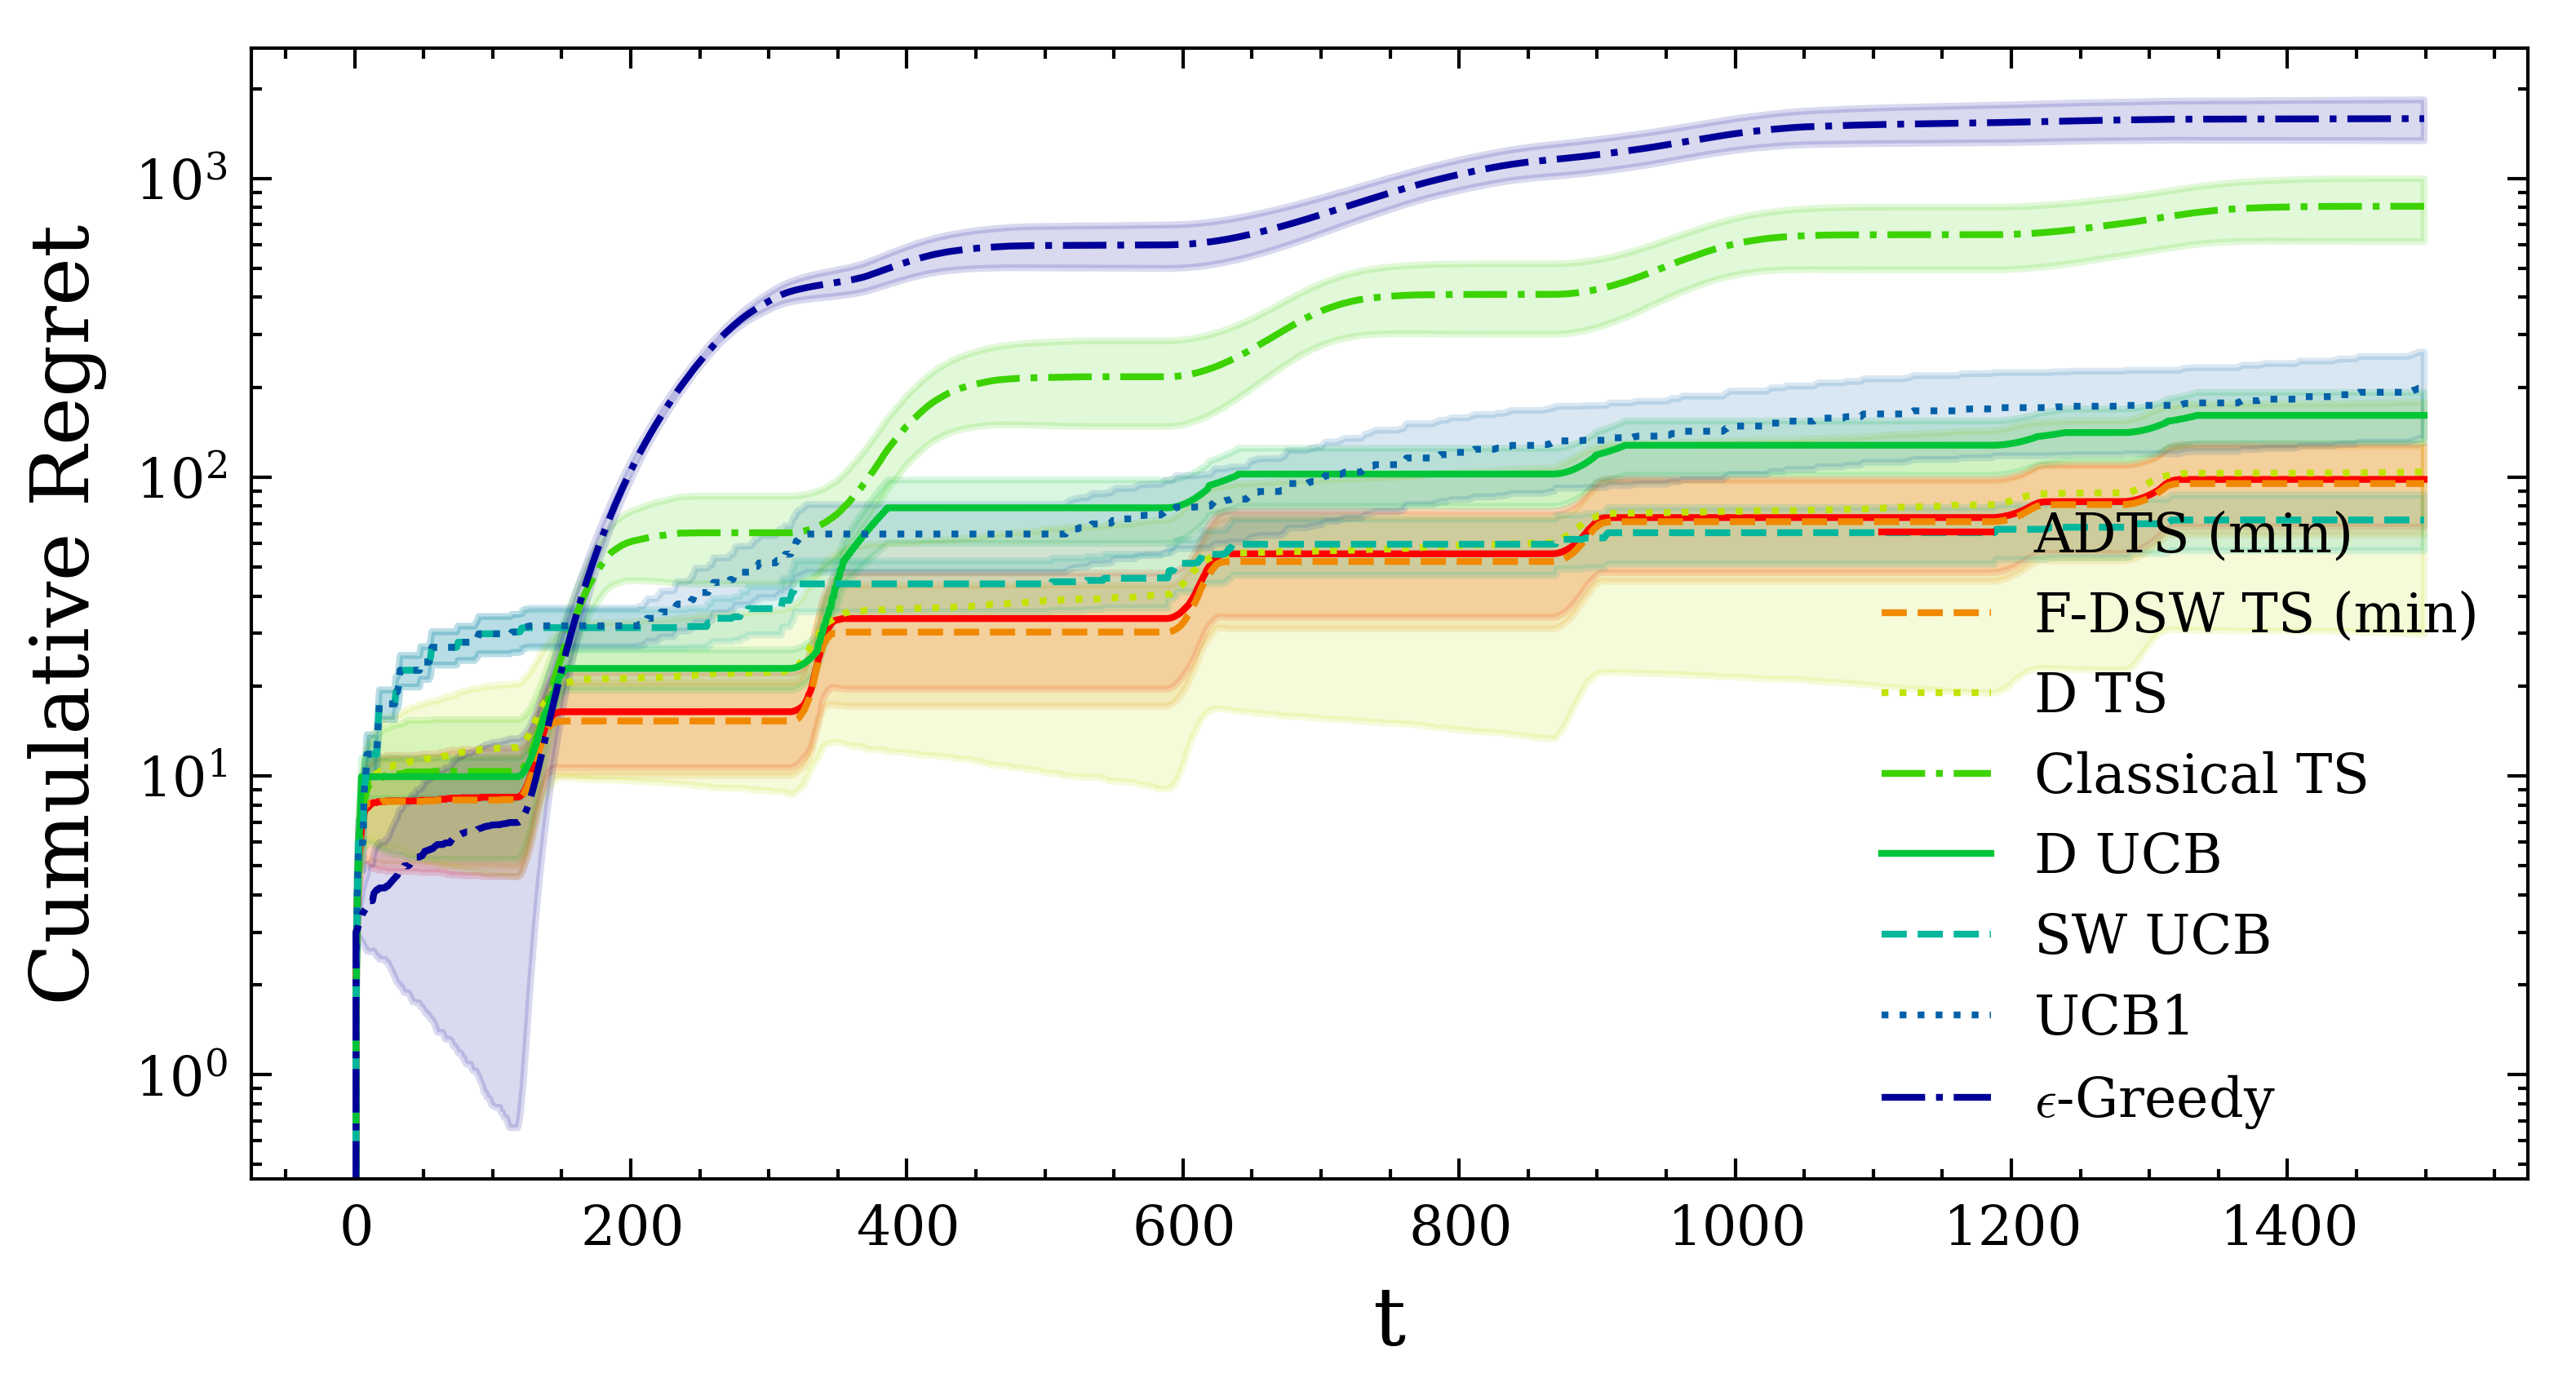

In [43]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6, 3))
    i = 0
    for policy, output in polices.items():
        plt.plot(np.cumsum(output["mean_regret"]), color=colors[i].rgb)
        confidence_interval = 1.96 * output["std_regret"] / np.sqrt(n_sim)
        upper = np.cumsum(output["mean_regret"] + confidence_interval)
        lower = np.cumsum(output["mean_regret"] - confidence_interval)
        plt.fill_between(list(range(len(output["mean_regret"]))), upper, lower, color=colors[i].rgb, alpha=0.15, label='_nolegend_')
        i += 1
    plt.legend([p for p in polices.keys()])
    plt.xlabel('t', fontsize=12)
    plt.ylabel('Cumulative Regret', fontsize=12)
    plt.yscale('log')
#     plt.grid(True)
    plt.savefig('02_cumulative_regrets_log.jpg', dpi=600)

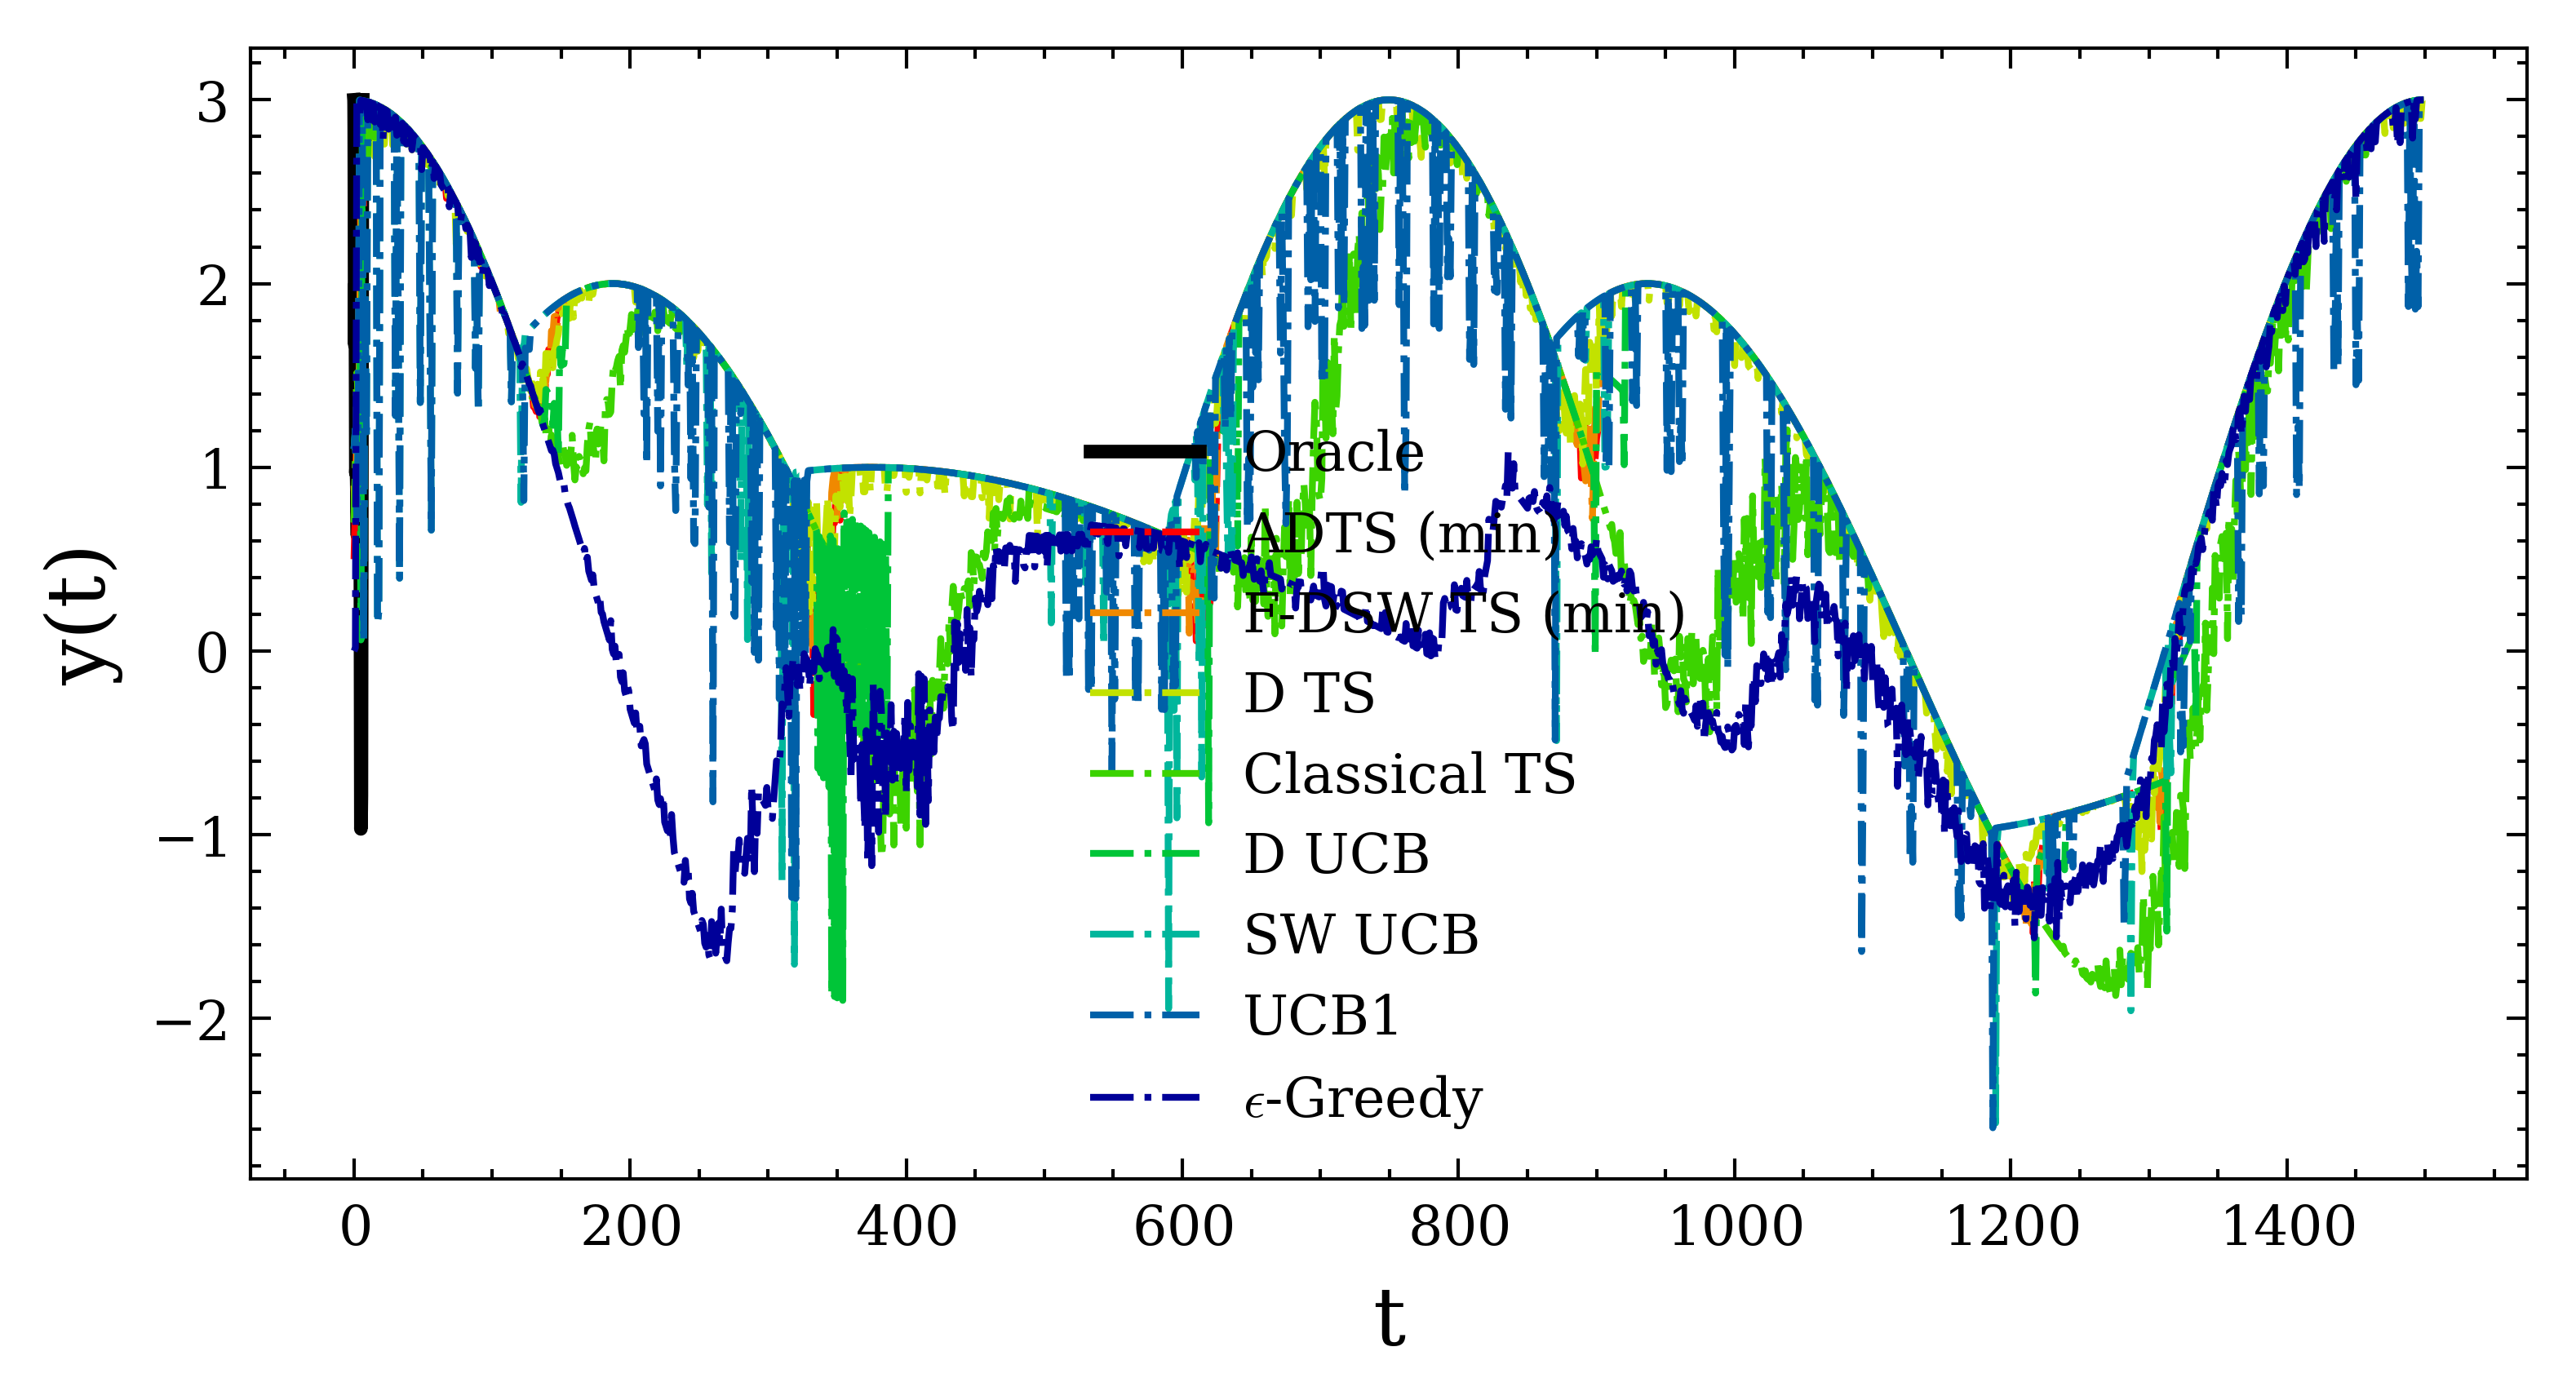

In [11]:
with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(6, 3))
    oracle = portfolio.max(axis=1)
    plt.plot(oracle, linewidth=2)
    legend = ["Oracle"]
    i = 0
    for policy, output in polices.items():
        plt.plot(output["mean_reward"], color=colors[i].rgb, linestyle="-.")
        legend.append(policy)
        i+=1
    
    plt.xlabel('t', fontsize=12)
    plt.ylabel('y(t)', fontsize=12)
    plt.legend(legend)
    plt.savefig('03_rewards_versus_oracle.jpg', dpi=600)

# 2. Tabulating  Accumulated Regrets

In [12]:
n_sim = 100
shift = 0
polices = {
    "ADTS (min)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "min", "w": 30},
        "agents": [],
    },
    "F-DSW TS (min)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "min", "n": 30},
        "agents": [],
    },
    "ADTS (max)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "max", "w": 30},
        "agents": [],
    },
    "F-DSW TS (max)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "max", "n": 30},
        "agents": [],
    },
    "ADTS (mean)": {
        "policy_name": "AdaptiveDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "mean", "w": 30},
        "agents": [],
    },
    "F-DSW TS (mean)": {
        "policy_name": "CavenaghiFDSWTS",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99, "f": "mean", "n": 30},
        "agents": [],
    },
    "D TS": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.99},
        "agents": [],
    },
    "Classical TS": {
        "policy_name": "ThompsonSampling",
        "args": {"n_arms": portfolio.shape[1]},
        "agents": [],
    },
    "D UCB": {
        "policy_name": "DiscountedUCB1",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.1},
        "agents": [],
    },
    "SW UCB": {
        "policy_name": "SlidingWindowUCB1",
        "args": {"n_arms": portfolio.shape[1], "w": 50},
        "agents": [],
    },
    "UCB1": {
        "policy_name": "UCB1",
        "args": {"n_arms": portfolio.shape[1]},
        "agents": [],
    },
    "$\epsilon$-Greedy": {
        "policy_name": "EpsilonGreedy",
        "args": {"n_arms": portfolio.shape[1], "epsilon": 0.02},
        "agents": [],
    },
}
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=LastReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["rewards_mxt"] = rewards_mxt
    polices[policy_name]["regret_mxt"] = regret_mxt
    polices[policy_name]["std_reward"] = np.std(rewards_mxt, axis=1)
    polices[policy_name]["mean_reward"] = np.mean(rewards_mxt, axis=1)
    polices[policy_name]["std_regret"] = np.std(regret_mxt, axis=1)
    polices[policy_name]["mean_regret"] = np.mean(regret_mxt, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:40<00:00,  2.45it/s]


In [13]:
import numpy as np

# Generate LaTeX table
table = "\\begin{table}[h]\n"
table += "\\centering\n"
table += "\\begin{tabular}{lcc}\n"
table += "\\hline\n"
table += "Algorithm & Mean Cumulative Regret $\\pm$ Std Dev \\\\\n"
table += "\\hline\n"
for policy, output in polices.items():
    mean_regret = np.cumsum(output["mean_regret"])
    confidence_interval = 1.96 * output["std_regret"] / np.sqrt(n_sim)
    upper = np.cumsum(output["mean_regret"] + confidence_interval)
    lower = np.cumsum(output["mean_regret"] - confidence_interval)
    table += f"{policy} & ${mean_regret[-1]:.1f} \\pm {(upper[-1] - mean_regret[-1]):.1f}$ \\\\\n"
table += "\\hline\n"
table += "\\end{tabular}\n"
table += "\\caption{Comparison of Mean Cumulative Regrets with Std Dev for Various MAB Algorithms (based on 100 simulations)}\n"
table += "\\end{table}\n"

print(table)


\begin{table}[h]
\centering
\begin{tabular}{lcc}
\hline
Algorithm & Mean Cumulative Regret $\pm$ Std Dev \\
\hline
ADTS (min) & $98.6 \pm 22.1$ \\
F-DSW TS (min) & $96.4 \pm 23.5$ \\
ADTS (max) & $253.3 \pm 58.1$ \\
F-DSW TS (max) & $91.6 \pm 33.8$ \\
ADTS (mean) & $119.2 \pm 28.7$ \\
F-DSW TS (mean) & $79.8 \pm 19.8$ \\
D TS & $102.8 \pm 60.3$ \\
Classical TS & $817.0 \pm 144.1$ \\
D UCB & $169.2 \pm 22.4$ \\
SW UCB & $71.9 \pm 10.8$ \\
UCB1 & $198.9 \pm 44.9$ \\
$\epsilon$-Greedy & $1540.4 \pm 210.7$ \\
\hline
\end{tabular}
\caption{Comparison of Mean Cumulative Regrets with Std Dev for Various MAB Algorithms (based on 100 simulations)}
\end{table}



## 2- Investigating the effect of discount (gamma) in d TS

In [14]:
gamma_vec = np.unique(np.append(np.linspace(0., 0.9, 10), np.linspace(0.95, 1, 11)))

In [15]:
gamma_vec

array([0.   , 0.1  , 0.2  , 0.3  , 0.4  , 0.5  , 0.6  , 0.7  , 0.8  ,
       0.9  , 0.95 , 0.955, 0.96 , 0.965, 0.97 , 0.975, 0.98 , 0.985,
       0.99 , 0.995, 1.   ])

In [16]:
n_sim = 50
polices = {
    f"D TS {i}": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i]},
        "agents": [],
    }
    for i in range(len(gamma_vec))
}
polices.update(
    {   
        f"ADTS (min) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "min", "w": 30},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (min) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": gamma_vec[i], "f": "min", "n": 30},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)
polices.update(
    {   
        f"Classical TS {i}": {
            "policy_name": "ThompsonSampling",
            "args": {"n_arms": portfolio.shape[1]},
            "agents": [],
        }
        for i in range(len(gamma_vec))
    }
)

In [17]:
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=LastReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["regret"] = np.mean(regret_mxt, axis=1).mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:25<00:00,  1.94it/s]
/Users/gfonseca/Desktop/Doutorado - EEC-I/Pesquisa/bandits-lib/venv/lib/python3.9/site-packages/multi_armed_bandit/algorithms/bernoulli_dist/min_dsw_ts.py:33: RuntimeWarning: invalid value encountered in scalar divide00:00<?, ?it/s]
  self._mean_trace[a].append(self._betas[a][1] / (self._betas[a][1] + self._betas[a][0]))
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:22<00:00,  2.27it/s]


In [18]:
groups = ["D TS", "ADTS (min)", "FDSWTS (min)", "Classical TS"]
results_dict = {}
for g in groups:
    results_dict[g] = {
        "gamma_vec": gamma_vec,
        "regret": []
    }
    for k, v in polices.items():
        if g in k:
            results_dict[g]["regret"].append(v["regret"])

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/835846183.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["regret"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/835846183.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/835846183.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyw

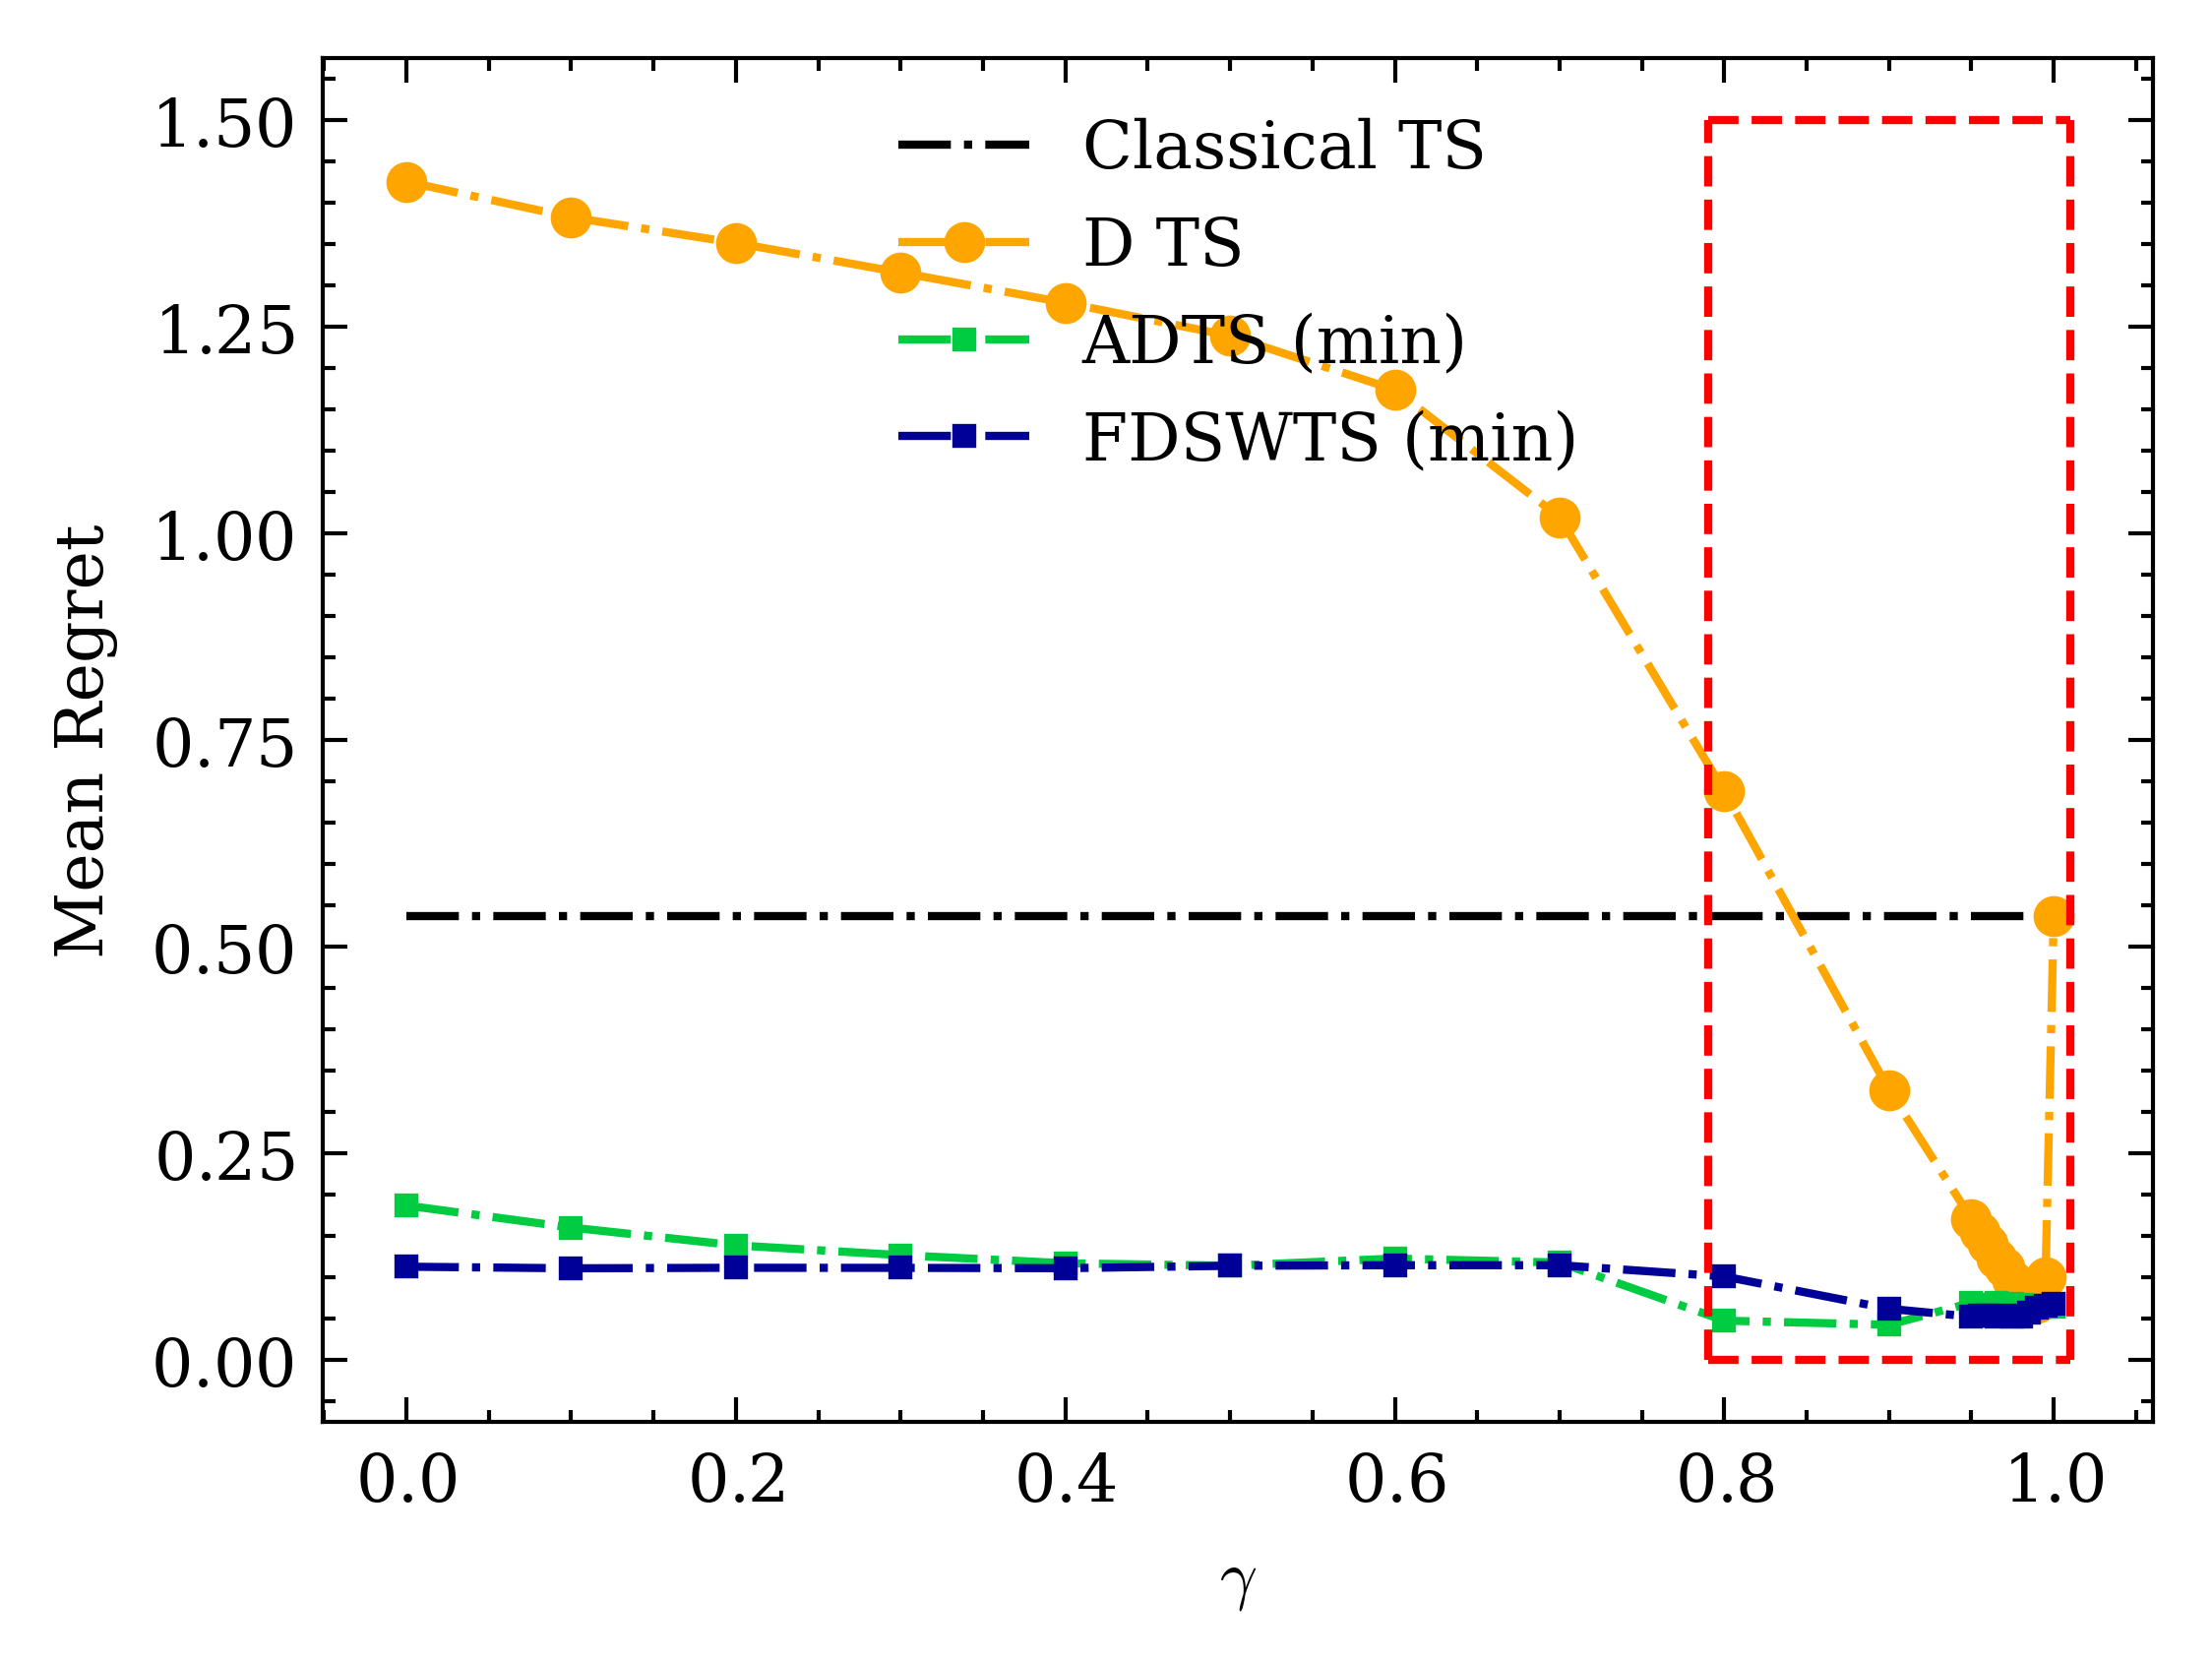

In [19]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

x_min = 0.79
x_max = 1.01
y_min = 0.
y_max = 1.5

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["Classical TS"]["gamma_vec"], results_dict["Classical TS"]["regret"], color="k", linestyle="-.")
    plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["regret"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
    plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
    plt.plot(results_dict["FDSWTS (min)"]["gamma_vec"], results_dict["FDSWTS (min)"]["regret"], "-s", markersize=2, color=colors[2].rgb, linestyle="-.")
    
    plt.plot([x_min, x_min], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    plt.plot([x_min, x_max], [y_max, y_max], color='r', linewidth=1, linestyle="--")
    plt.plot([x_max, x_max], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    plt.plot([x_min, x_max], [y_min, y_min], color='r', linewidth=1, linestyle="--")
    
    plt.xlabel(r'$\gamma$')
    plt.ylabel('Mean Regret')
    plt.legend(["Classical TS", "D TS", "ADTS (min)", "FDSWTS (min)"])
    plt.savefig('04_effect_of_gamma.jpg', dpi=600)

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/2558972403.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["regret"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/2558972403.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/2558972403.py:13: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The k

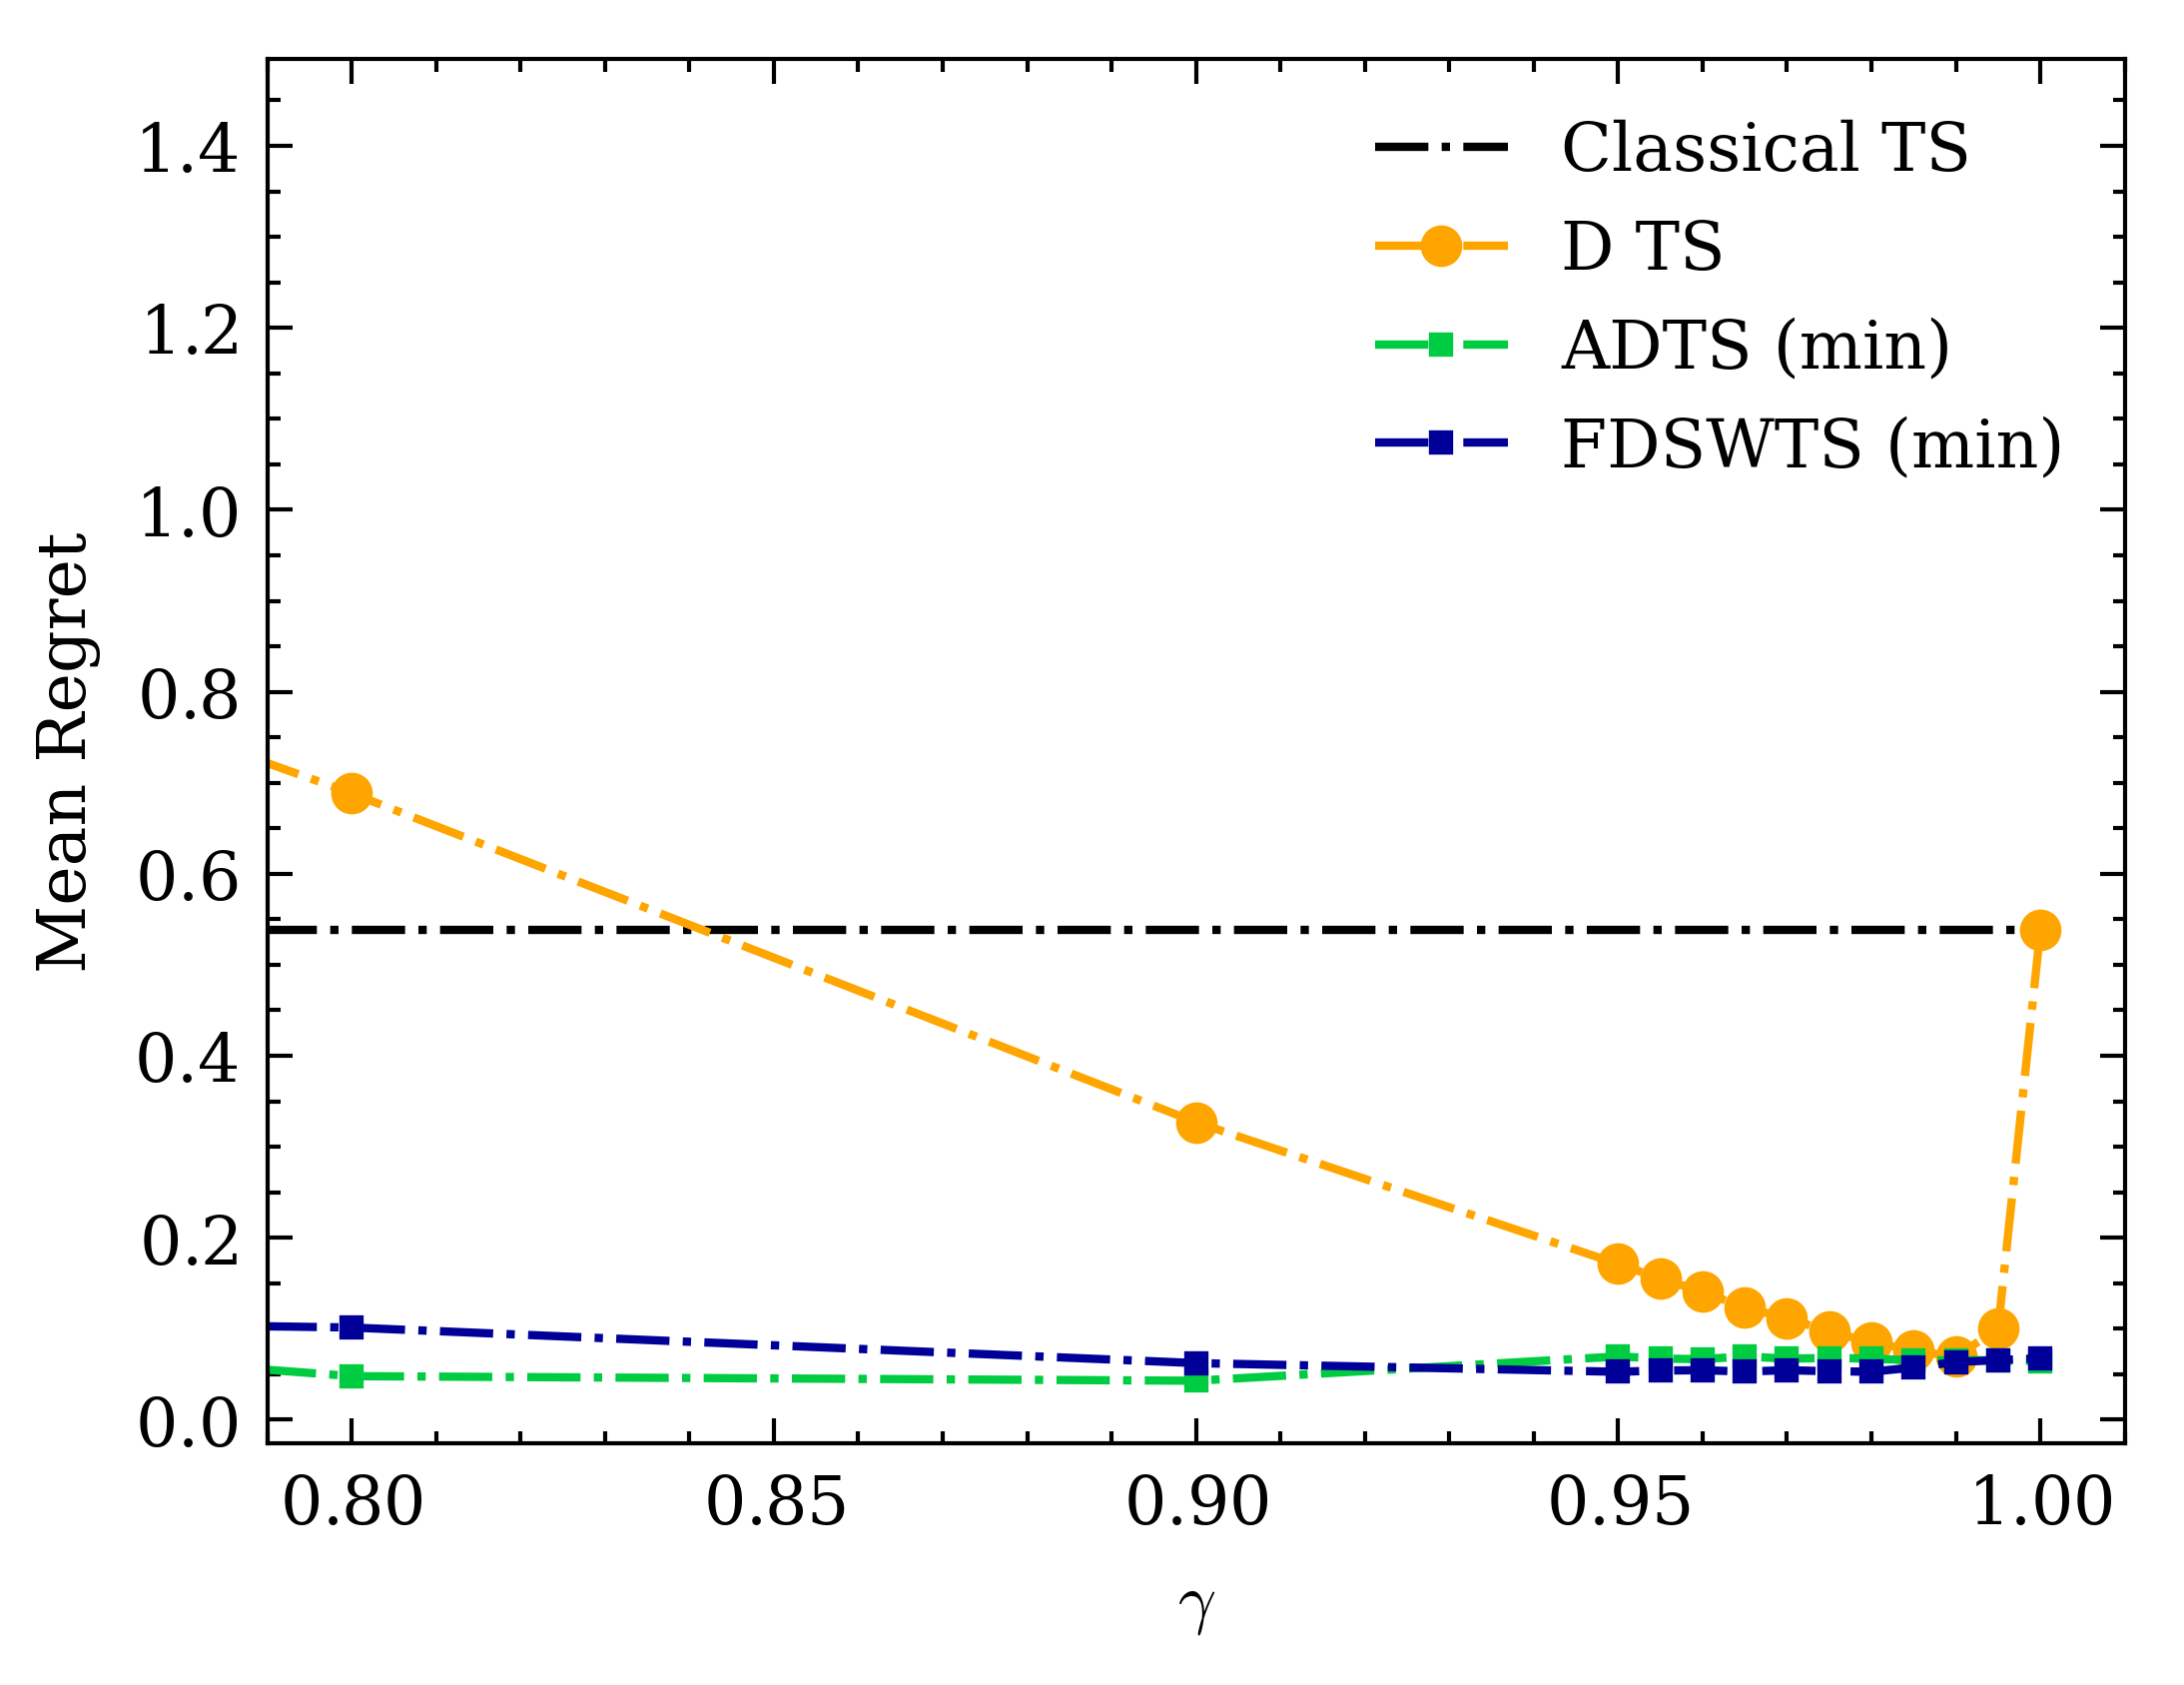

In [20]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["Classical TS"]["gamma_vec"], results_dict["Classical TS"]["regret"], color="k", linestyle="-.")
    plt.plot(results_dict["D TS"]["gamma_vec"], results_dict["D TS"]["regret"], "-o", markersize=4, color=colors[0].rgb, linestyle="-.")
    plt.plot(results_dict["ADTS (min)"]["gamma_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[1].rgb, linestyle="-.")
    plt.plot(results_dict["FDSWTS (min)"]["gamma_vec"], results_dict["FDSWTS (min)"]["regret"], "-s", markersize=2, color=colors[2].rgb, linestyle="-.")
    
    plt.xlabel(r'$\gamma$')
    plt.ylabel('Mean Regret')
    plt.legend(["Classical TS", "D TS", "ADTS (min)", "FDSWTS (min)"])
    plt.xlim([0.79, 1.01])
    plt.savefig('04_effect_of_gamma_zoom.jpg', dpi=600)

## 3- Investigating the window size (w) on sw-d TS

In [21]:
w_vec = np.unique(np.append(np.linspace(0, 50, 11), np.linspace(100, 1000, 7)))

In [22]:
w_vec[0] = 1

In [23]:
w_vec

array([   1.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
         45.,   50.,  100.,  250.,  400.,  550.,  700.,  850., 1000.])

In [24]:
n_sim = 30
polices = {
    f"D TS {i}": {
        "policy_name": "BetaDiscountedThompsonSampling",
        "args": {"n_arms": portfolio.shape[1], "gamma": 0.98},
        "agents": [],
    }
    for i in range(len(w_vec))
}
polices.update(
    {   
        f"ADTS (min) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.98, "f": "min", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"ADTS (mean) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.98, "f": "mean", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"ADTS (max) {i}": {
            "policy_name": "AdaptiveDiscountedThompsonSampling",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.98, "f": "max", "w": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (min) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.98, "f": "min", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (mean) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.98, "f": "mean", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)
polices.update(
    {   
        f"FDSWTS (max) {i}": {
            "policy_name": "CavenaghiFDSWTS",
            "args": {"n_arms": portfolio.shape[1], "gamma": 0.98, "f": "max", "n": int(w_vec[i])},
            "agents": [],
        }
        for i in range(len(w_vec))
    }
)

In [25]:
seeds = list(range(n_sim))
for policy_name, args in polices.items():
    rewards_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    regret_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    chosen_arms_mxt = np.zeros(shape=(portfolio.shape[0], n_sim))
    for i in tqdm(range(n_sim)):
        kwargs = args["args"].copy()
        kwargs["seed"] = seeds[i]
        rewards, policy = run_backtest(
            policy_name=args["policy_name"],
            policy_args=kwargs,
            portfolio=portfolio,
            arm=LastReturnArm()
        )
        rewards_mxt[:, i] = np.array(rewards)
        regret_mxt[:, i] = np.array(policy.regret)
        polices[policy_name]["agents"].append(policy)
    polices[policy_name]["regret"] = np.mean(regret_mxt, axis=1).mean()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:13<00:00,  2.17it/s]


In [26]:
# groups = ["d TS", "min d-sw TS", "avg d-sw TS", "max d-sw TS", "Classical TS"]
groups = ["D TS", "ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"]
results_dict = {}
for g in groups:
    results_dict[g] = {
        "w_vec": w_vec,
        "regret": []
    }
    for k, v in polices.items():
        if g in k:
            results_dict[g]["regret"].append(v["regret"])

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/1163624019.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/1163624019.py:17: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["regret"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/1163624019.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-^" (-> linestyle='-'). T

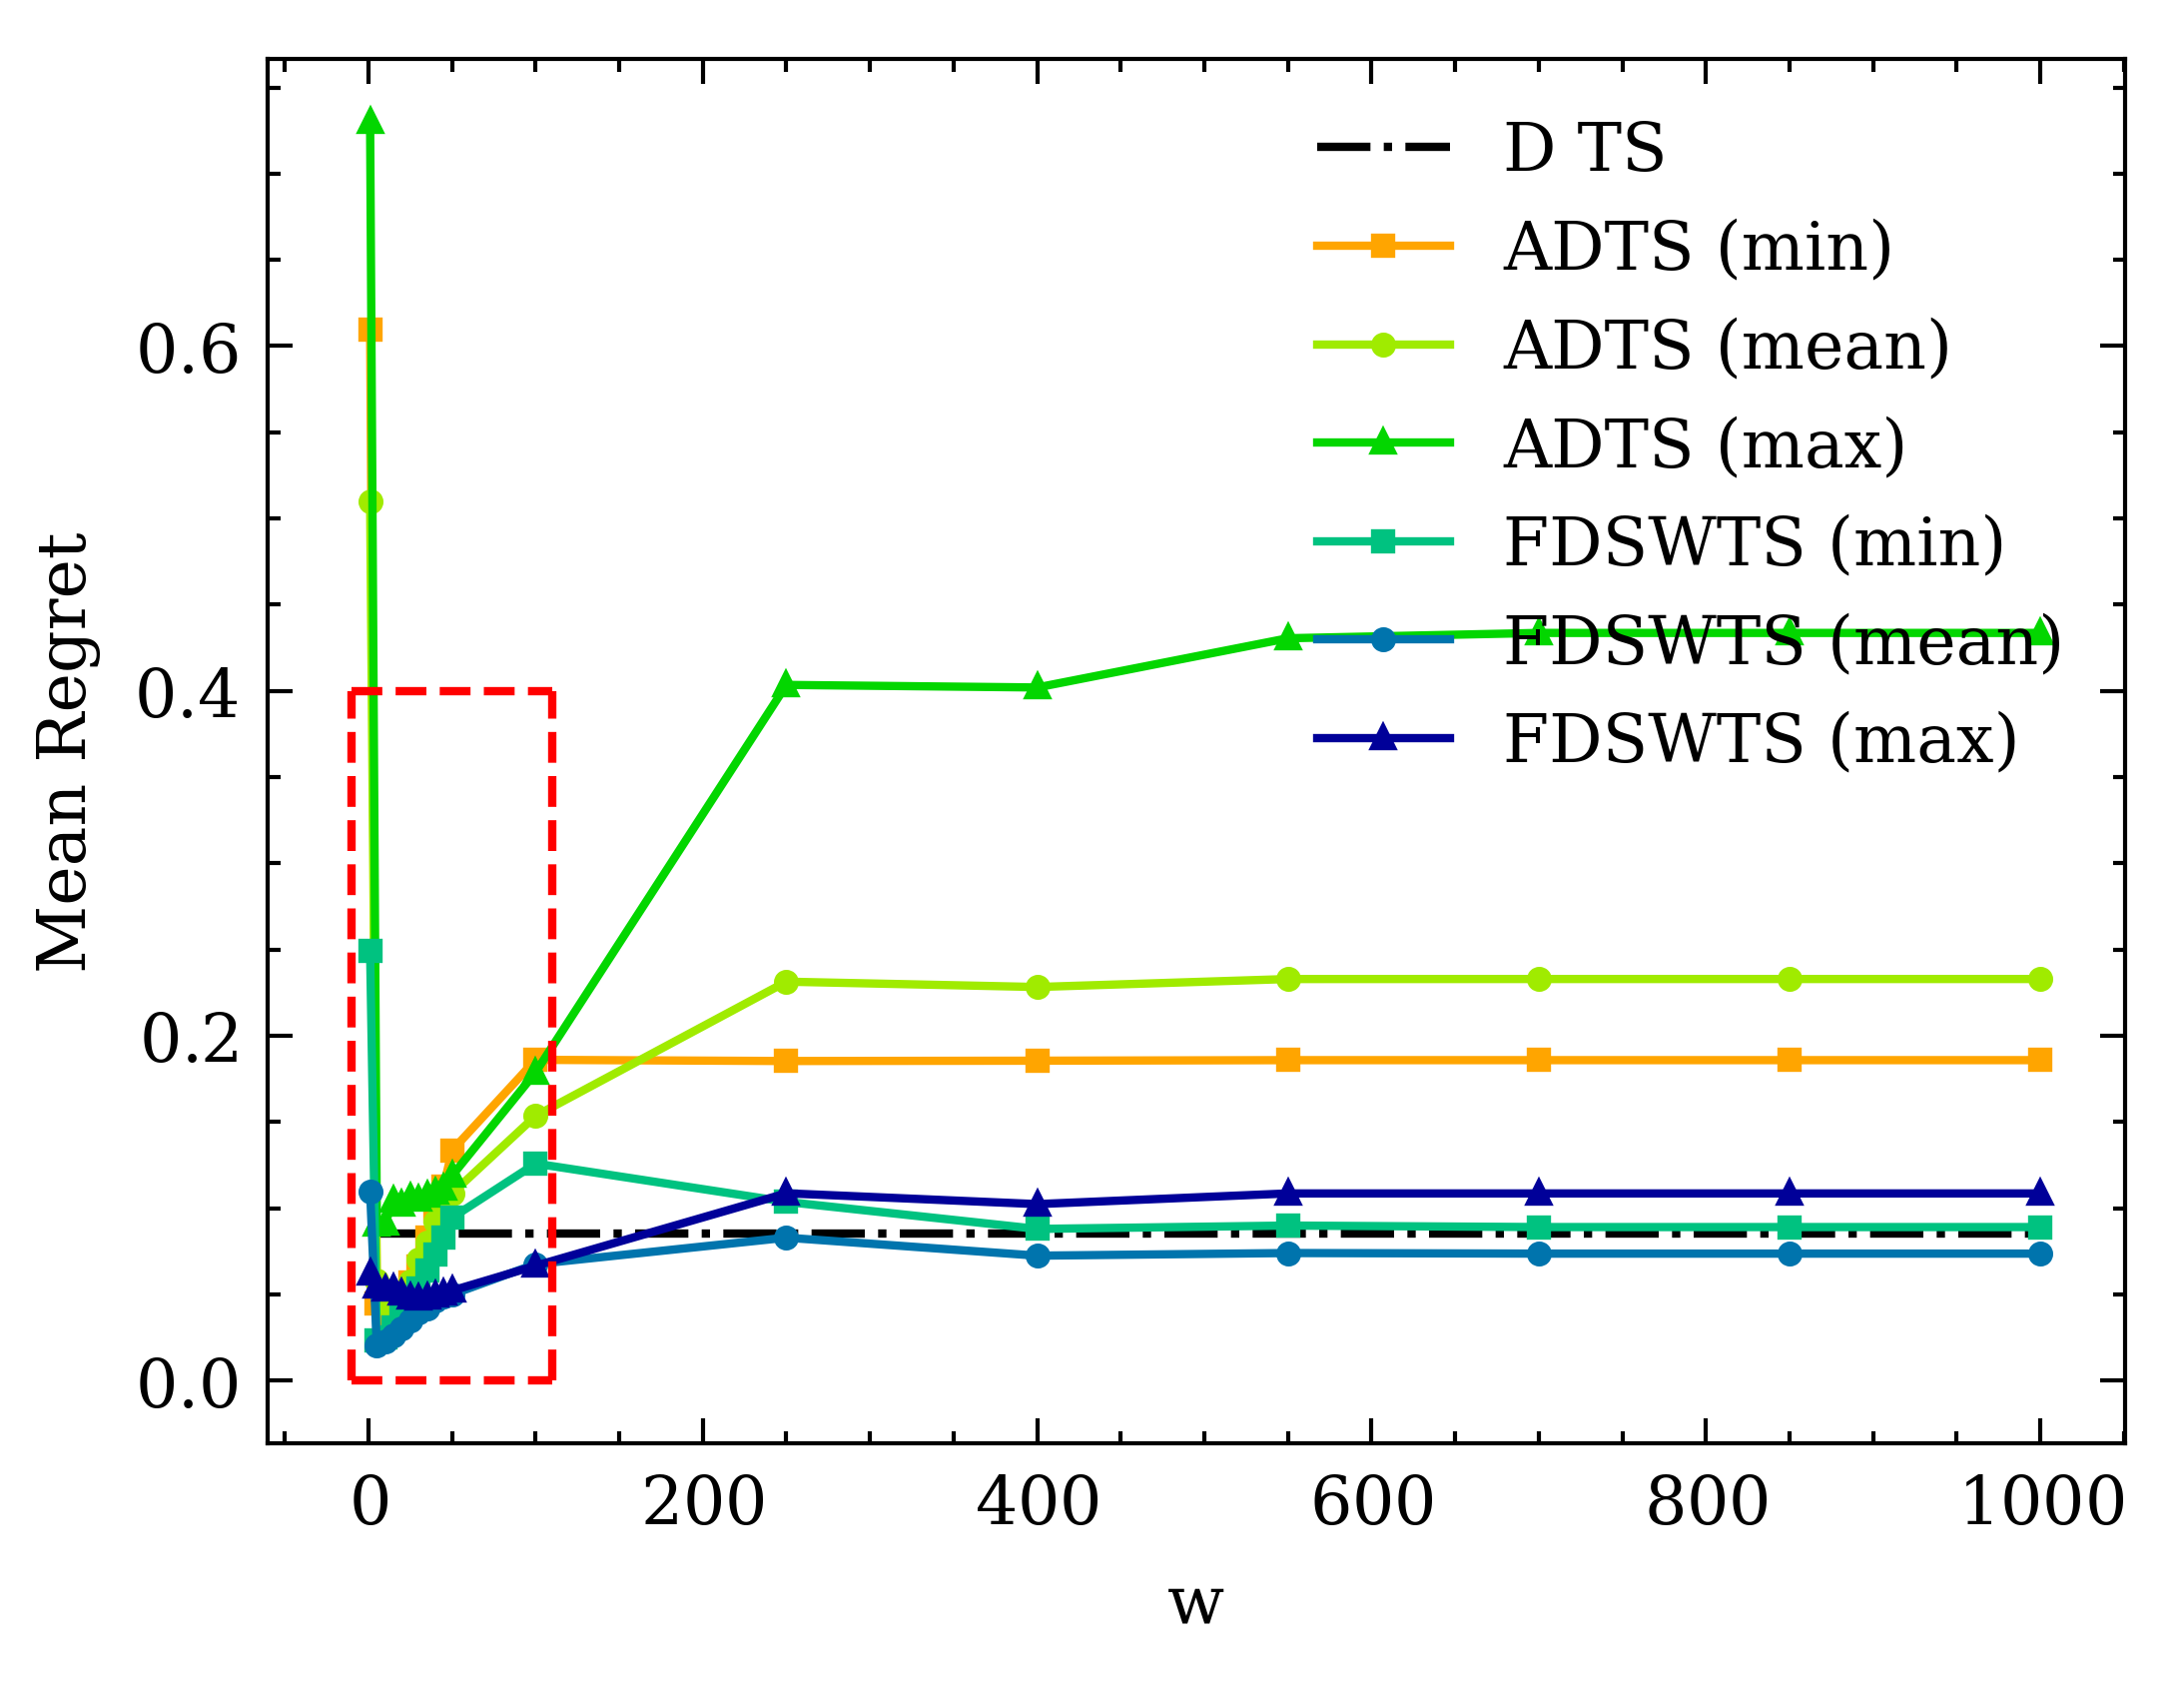

In [38]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

x_min = -10
x_max = 110
y_min = 0.
y_max = 0.4

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["D TS"]["w_vec"], results_dict["D TS"]["regret"], color="k", linestyle="-.")
    plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
    plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["regret"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
    plt.plot(results_dict["ADTS (max)"]["w_vec"], results_dict["ADTS (max)"]["regret"], "-^", markersize=2, color=colors[2].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (min)"]["w_vec"], results_dict["FDSWTS (min)"]["regret"], "-s", markersize=2, color=colors[3].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (mean)"]["w_vec"], results_dict["FDSWTS (mean)"]["regret"], "-o", markersize=2, color=colors[4].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (max)"]["w_vec"], results_dict["FDSWTS (max)"]["regret"], "-^", markersize=2, color=colors[5].rgb, linestyle="-")
    
    plt.plot([x_min, x_min], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    plt.plot([x_min, x_max], [y_max, y_max], color='r', linewidth=1, linestyle="--")
    plt.plot([x_max, x_max], [y_min, y_max], color='r', linewidth=1, linestyle="--")
    plt.plot([x_min, x_max], [y_min, y_min], color='r', linewidth=1, linestyle="--")
#     plt.plot(results_dict["d $\sigma$-TS"]["gamma_vec"], results_dict["d $\sigma$-TS"]["regret"], "-^", markersize=2, color=colors[2].rgb, linestyle="-.")
#     for k, v in results_dict.items():
#         plt.plot(v["gamma_vec"], v["regret"], color=colors[i].rgb, linestyle="-.")
#         plt.scatter(v["gamma_vec"], v["regret"], s=2, c=colors[i].rgb)#, linestyle="-.")
#         legend.append(k)
#         i+=1
    plt.xlabel('w')
    plt.ylabel('Mean Regret')
    plt.legend(["D TS", "ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"])
    plt.savefig('05_effect_of_w.jpg', dpi=600)

/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/3473474818.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-s" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/3473474818.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["regret"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
/var/folders/pr/c2dbtqtn2td9ylt9lvrqnrxc0000gn/T/ipykernel_24216/3473474818.py:12: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-^" (-> linestyle='-'). T

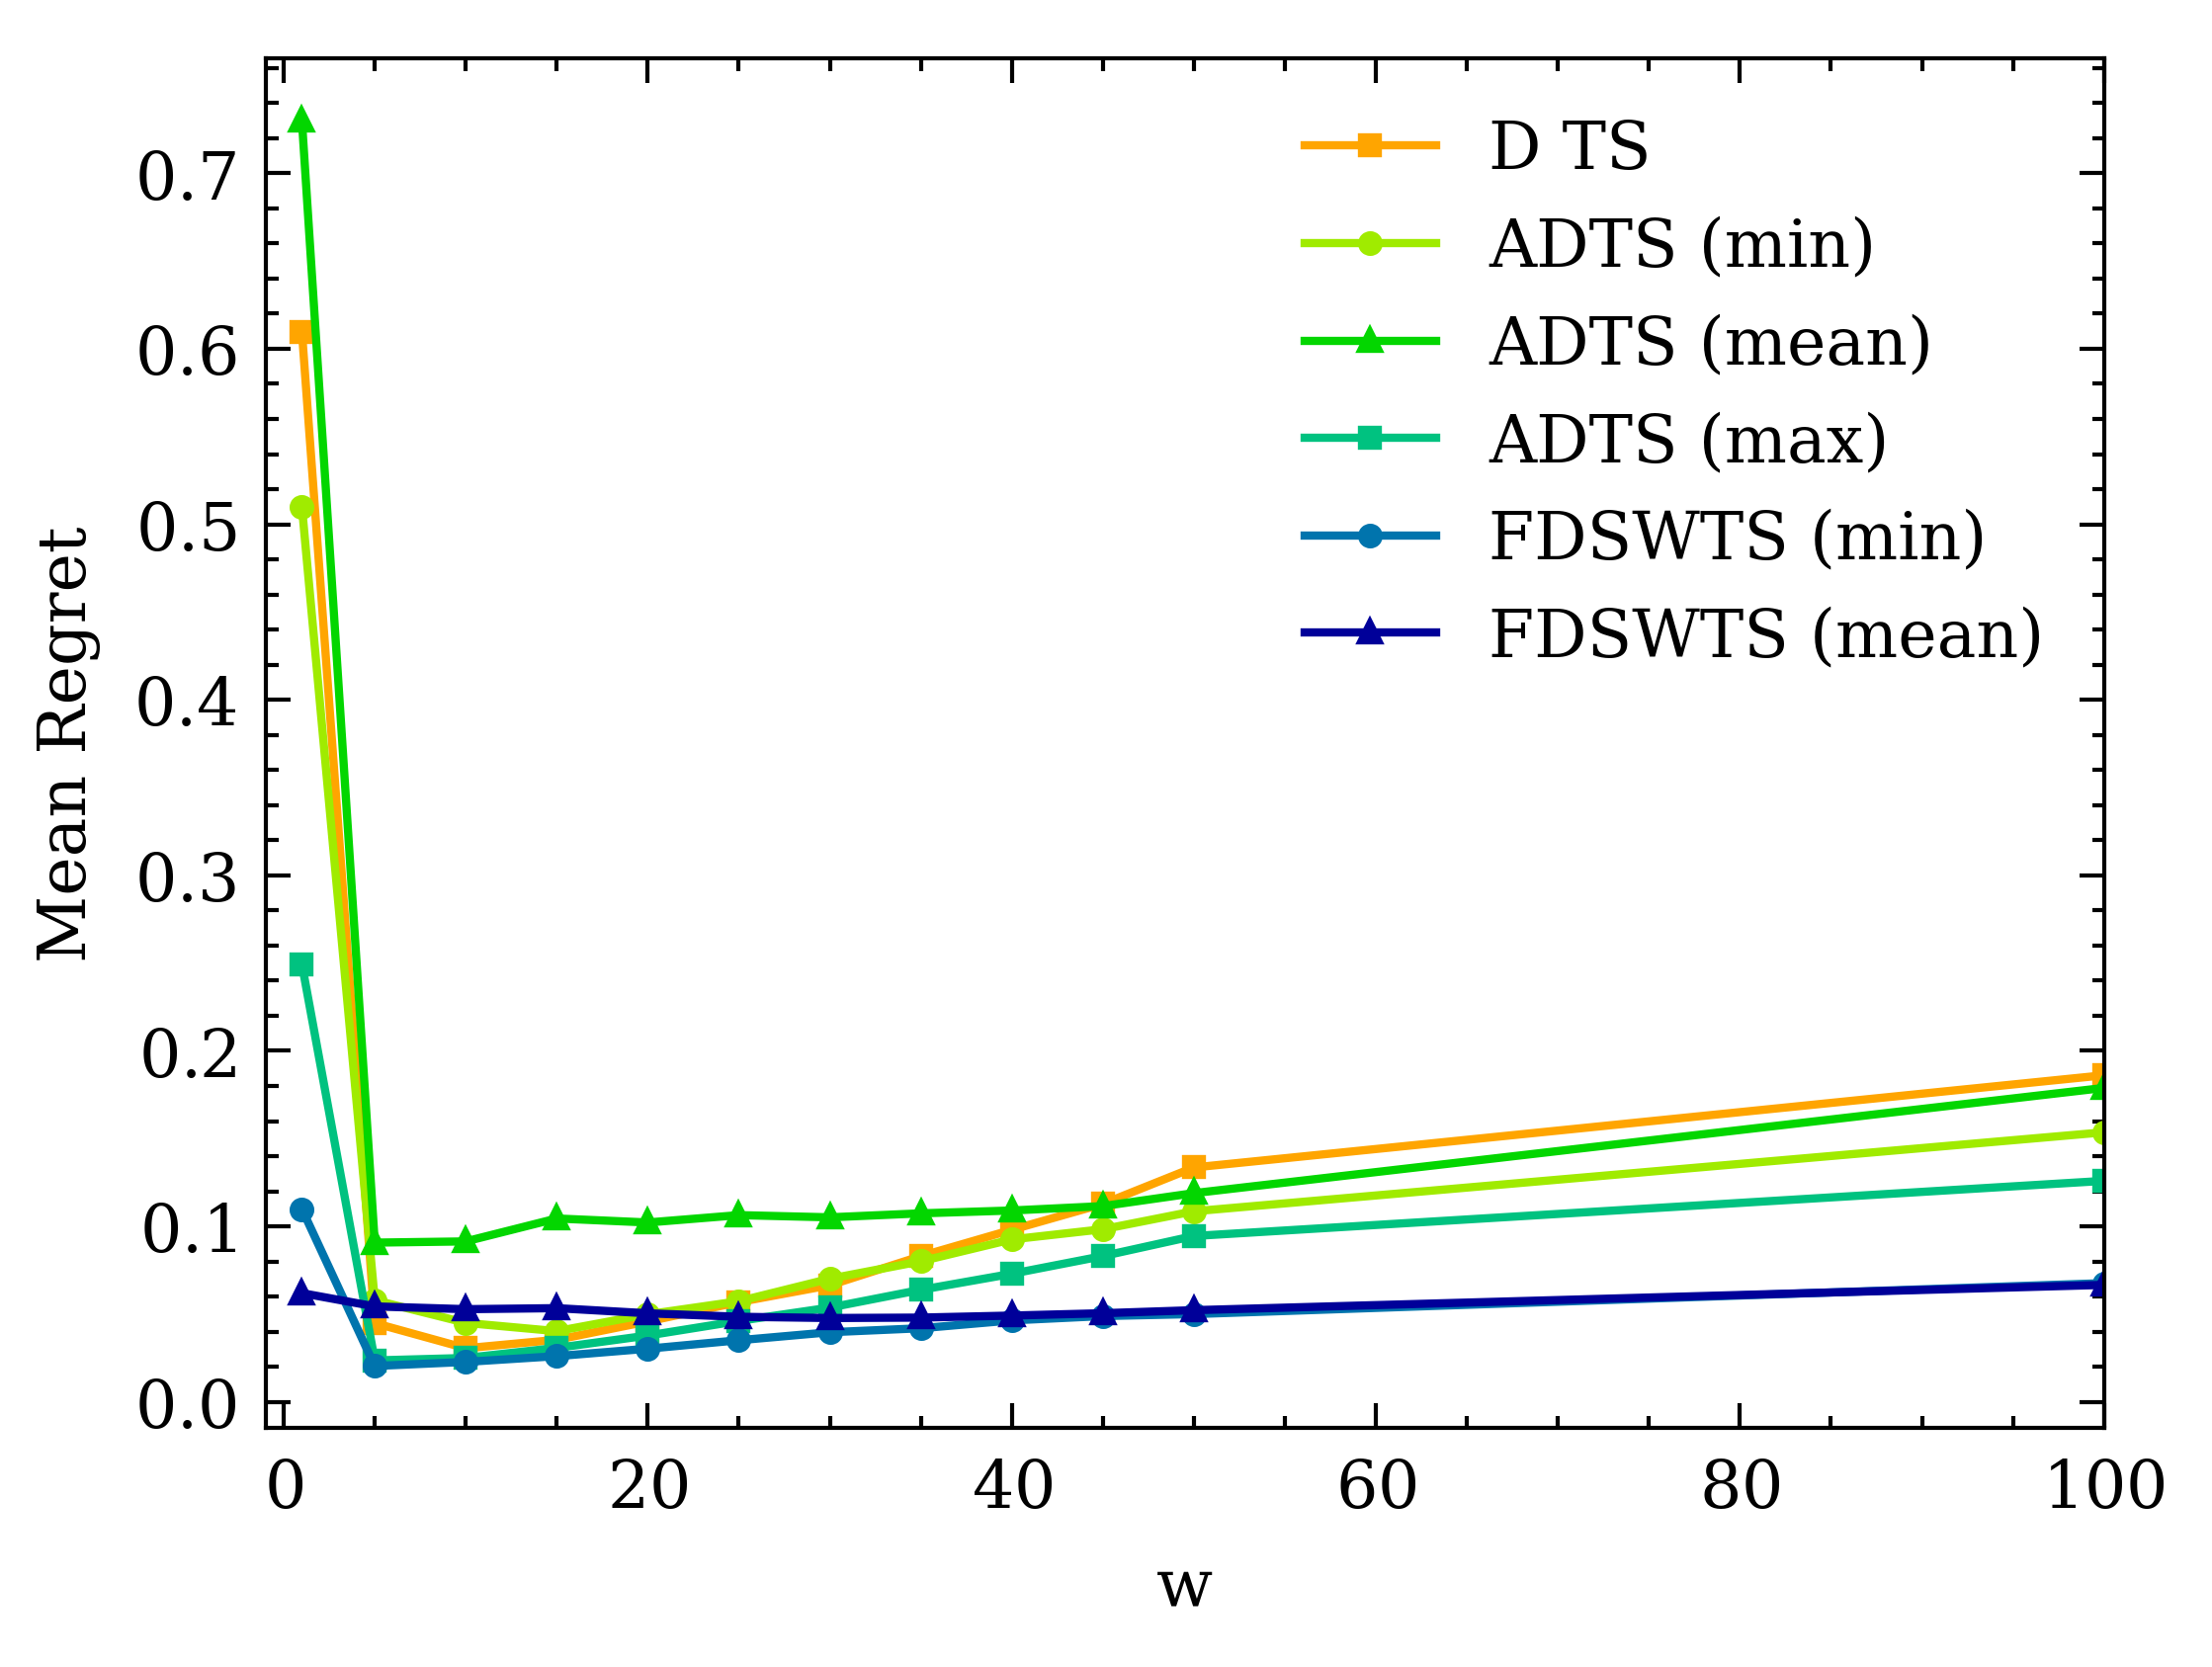

In [39]:
from colour import Color

blue = Color("orange")
colors = list(blue.range_to(Color("blue", luminance=0.3), len(results_dict)-1))

with plt.style.context(['science', 'ieee', 'no-latex']):
    fig, ax = plt.subplots(figsize=(4, 3))
    legend = []
    i = 0
    plt.plot(results_dict["ADTS (min)"]["w_vec"], results_dict["ADTS (min)"]["regret"], "-s", markersize=2, color=colors[0].rgb, linestyle="-")
    plt.plot(results_dict["ADTS (mean)"]["w_vec"], results_dict["ADTS (mean)"]["regret"], "-o", markersize=2, color=colors[1].rgb, linestyle="-")
    plt.plot(results_dict["ADTS (max)"]["w_vec"], results_dict["ADTS (max)"]["regret"], "-^", markersize=2, color=colors[2].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (min)"]["w_vec"], results_dict["FDSWTS (min)"]["regret"], "-s", markersize=2, color=colors[3].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (mean)"]["w_vec"], results_dict["FDSWTS (mean)"]["regret"], "-o", markersize=2, color=colors[4].rgb, linestyle="-")
    plt.plot(results_dict["FDSWTS (max)"]["w_vec"], results_dict["FDSWTS (max)"]["regret"], "-^", markersize=2, color=colors[5].rgb, linestyle="-")
    plt.xlabel('w')
    plt.ylabel('Mean Regret')
    plt.legend(["D TS", "ADTS (min)", "ADTS (mean)", "ADTS (max)", "FDSWTS (min)", "FDSWTS (mean)", "FDSWTS (max)"])
    plt.xlim([-1, 100])
    plt.savefig('05_effect_of_w_zoom_0_50.jpg', dpi=600)